In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                          UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
import keras
import tensorflow as tf
from keras import callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras import optimizers


Using TensorFlow backend.


In [3]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17439615350108243812
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3151455846
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9190131075775798623
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
datadir = 'D:\sapienza\ML\MWI-Dataset'


In [3]:
testdir = 'D:\sapienza\ML\Weather_dataset'


In [9]:
batch_size = 5
input_shape = ()
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False,
    validation_split=0.2)

In [11]:
train_generator = train_datagen.flow_from_directory(
    directory=datadir,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset='training',
    seed=7
)

Found 320 images belonging to 4 classes.


In [12]:
validation_generator = train_datagen.flow_from_directory(
    directory=datadir,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset='validation',
    seed=7
)

Found 80 images belonging to 4 classes.


In [13]:
num_samples = train_generator.n
input_shape = train_generator.image_shape
classnames = [k for k,v in train_generator.class_indices.items()]


HAZE


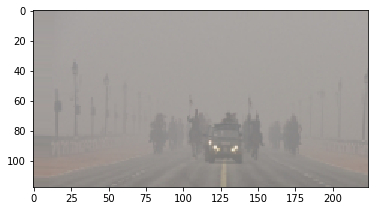

SNOWY


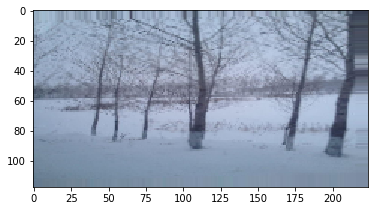

HAZE


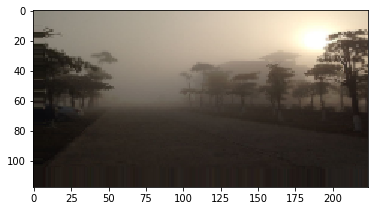

In [13]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

In [14]:
def RandNet(input_shape, num_classes):
    
    model = Sequential(name="RandNet")
    
    model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_shape, padding="valid"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())
    
    
    model.add(Conv2D(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
    model.add(BatchNormalization())


   # model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='valid'))
   # model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
   # model.add(BatchNormalization())


    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))


    optimizer = 'sgd' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [15]:
model = RandNet(input_shape, 4)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 117, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 116, 222, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 116, 222, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 111, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 57, 110, 32)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 57, 110, 32)       128       
_____________________

In [16]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [17]:
stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4)

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size

try:
    history = model.fit_generator(train_generator, epochs=20, verbose=1, callbacks=[stopping,checkpointer],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=validation_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20


C:\Users\Theo\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


64/64 [==============================] - 9s 143ms/step - loss: 1.3523 - acc: 0.5625 - val_loss: 1.1238 - val_acc: 0.5875

Epoch 00001: val_acc improved from -inf to 0.58750, saving model to best_weights.hdf5
Epoch 2/20
64/64 [==============================] - 4s 66ms/step - loss: 0.9589 - acc: 0.6156 - val_loss: 1.1765 - val_acc: 0.5500

Epoch 00002: val_acc did not improve from 0.58750
Epoch 3/20
64/64 [==============================] - 5s 74ms/step - loss: 0.9320 - acc: 0.6563 - val_loss: 1.3420 - val_acc: 0.5500

Epoch 00003: val_acc did not improve from 0.58750
Epoch 4/20
64/64 [==============================] - 4s 69ms/step - loss: 0.7954 - acc: 0.7250 - val_loss: 0.8949 - val_acc: 0.6750

Epoch 00004: val_acc improved from 0.58750 to 0.67500, saving model to best_weights.hdf5
Epoch 5/20
64/64 [==============================] - 4s 64ms/step - loss: 0.7576 - acc: 0.7094 - val_loss: 1.2431 - val_acc: 0.6250

Epoch 00005: val_acc did not improve from 0.67500
Epoch 6/20
64/64 [=======

In [51]:
model.load_weights('best_weights.hdf5')


In [18]:
loss,acc = model.evaluate_generator(validation_generator,verbose=1,steps=val_steps)
print('validation loss: %f' %loss)
print('validation accuracy: %f' %acc)



16/16 [==============================] - 1s 74ms/step
validation loss: 0.656457
validation accuracy: 0.775000


In [19]:
test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testdir,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3038 images belonging to 4 classes.


RAINY


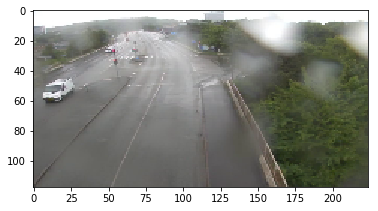

RAINY


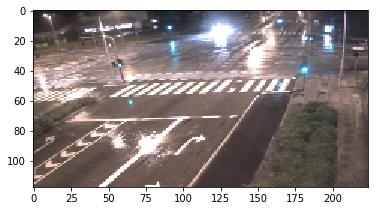

RAINY


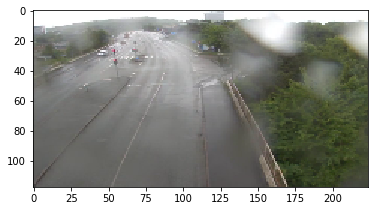

RAINY


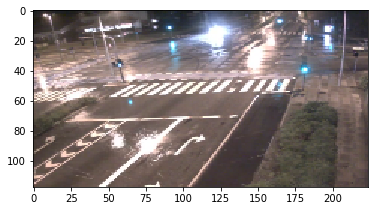

RAINY


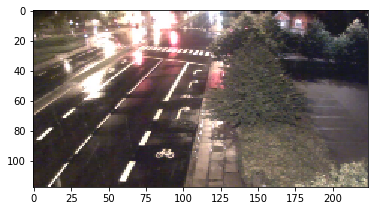

In [19]:
x,y = test_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,5):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

In [20]:
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

608/608 [==============================] - 35s 58ms/step
Test loss: 2.471421
Test accuracy: 0.471692


In [21]:
test_generator.reset()


pred = model.predict_generator(test_generator,verbose=1,steps=val_steps)

predicted_class_indices=np.argmax(pred,axis=1)
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]


#Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator


target_names = ['HAZE', 'RAINY', 'SNOWY','SUNNY']

print(classification_report(Ytest, predicted_class_indices, labels=None, target_names=target_names, digits=3))

608/608 [==============================] - 22s 36ms/step
              precision    recall  f1-score   support

        HAZE      0.000     0.000     0.000         0
       RAINY      0.315     0.637     0.421       521
       SNOWY      0.698     0.734     0.716      1421
       SUNNY      0.624     0.053     0.098      1096

   micro avg      0.472     0.472     0.472      3038
   macro avg      0.409     0.356     0.309      3038
weighted avg      0.606     0.472     0.442      3038



C:\Users\Theo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [22]:
confusion_matrix(Ytest,predicted_class_indices,labels=[0,1,2,3])

array([[   0,    0,    0,    0],
       [   0,  106,  400,   15],
       [   0,  401, 1005,   15],
       [   2,  649,  405,   40]], dtype=int64)

In [22]:
cm = confusion_matrix(Ytest, predicted_class_indices)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
      for j in range(0,cm.shape[1]):
            if (i!=j and cm[i][j]>0):
                  conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
      print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SUNNY            ->  RAINY             	573 	18.86 % 
SUNNY            ->  SNOWY             	350 	11.52 % 
SNOWY            ->  HAZE              	202 	6.65 % 
SNOWY            ->  RAINY             	150 	4.94 % 
SUNNY            ->  HAZE              	115 	3.79 % 
RAINY            ->  SNOWY             	101 	3.32 % 
RAINY            ->  HAZE              	79 	2.60 % 
SNOWY            ->  SUNNY             	26 	0.86 % 
RAINY            ->  SUNNY             	9 	0.30 % 


In [25]:

def plot_history(history,name):

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

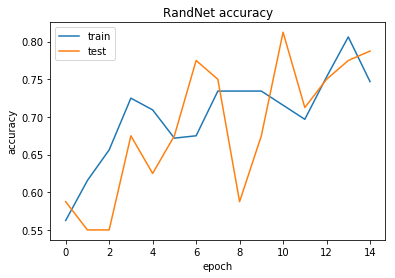

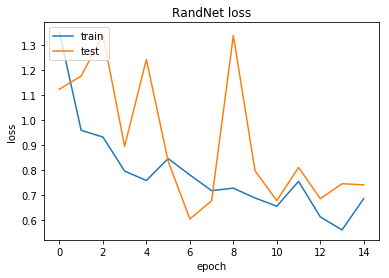

In [26]:
name="RandNet"
plot_history(history, name)